In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.optimization_data import TrainingData, PredictionData
from wufam.metrics.metrics import calc_sharpe

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_6

## 1.1

In [3]:
factors_df, rf = read_kf_data(
    factors_filename=PATH / DATASET,
    rf_filename=PATH / Dataset.RF,
    start_date=START,
    end_date=END,
)

## 1.2

In [4]:
from wufam.strategies.heuristics.equally_weighted import EWStrategy
from wufam.strategies.estimated.mean_var import MeanVariance
from wufam.strategies.estimated.min_var import MinVariance

trading_config = TradingConfig(total_exposure=1)

ew_strategy = EWStrategy()

In [5]:
from wufam.estimation.mean.sample_mu_estimator import SampleMuEstimator
from wufam.estimation.covariance.sample_cov_estimator import SampleCovEstimator

mv_strategy = MeanVariance(
    mu_estimator=SampleMuEstimator(),
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [6]:
from wufam.estimation.covariance.shrinkage.lw_cv_cov_estimator import (
    LedoitWolfCVCovEstimator,
)

min_var_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(alphas=np.linspace(0.0, 1.0, 100)),
    # cov_estimator=LedoitWolfCVCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [7]:
training_data = TrainingData(
    simple_excess_returns=factors_df,
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

In [8]:
prediction_data = PredictionData()

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In [9]:
ew_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [10]:
mv_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,-1.443996,-0.264279,3.017976,0.896614,-0.333317,-0.872997


In [11]:
min_var_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,-0.864741,-0.073944,1.76497,0.437395,0.613985,-0.877665


In [12]:
min_var_strategy.cov_estimator.best_alpha

np.float64(0.0)

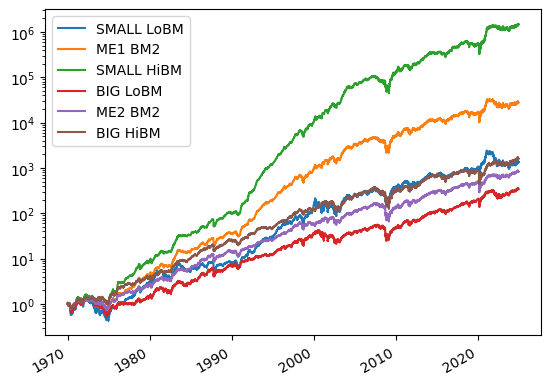

In [13]:
factors_df.add(1).cumprod().plot(logy=True);

In [14]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=factors_df,
    rf_rate=rf,
    factor_annualize=252,
)

1.592247434944696

In [15]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=factors_df,
    rf_rate=rf,
    factor_annualize=252,
)

2.3601159396244373

In [16]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=factors_df,
    rf_rate=rf,
    factor_annualize=252,
)

2.699828172605481

## 1.3.

In [17]:
split_date = factors_df.index[len(factors_df) // 2]

training_data = TrainingData(
    simple_excess_returns=factors_df.loc[:split_date],
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In [18]:
min_var_strategy.cov_estimator.best_alpha

np.float64(0.030303030303030304)

In-sample.

In [19]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=factors_df.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

2.3123958333741967

In [20]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=factors_df.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

3.9355252479774565

In [21]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=factors_df.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

4.126297333293169

Out-of-sample.

In [22]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=factors_df.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

0.5284882214073725

In [23]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=factors_df.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

1.1566128407324294

In [24]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=factors_df.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

0.9625686967798516